### LSTM长短记忆网络

    LSTM 由Hochreiter & Schmidhuber 于1997年提出，通过门控单元改善了RNN长期依赖问题。 
    Sepp Hochreiter,Jurgen Schmidhuber.LONG SHORT-TERM MEMORY.Neural Computation,December 1997.
    
    门限：[0,1]
    输入门（门限）：it = sigmoid(Wi * [ht_1 , xt ] + bi)
    遗忘门（门限）：ft = sigmoid(Wf * [ht_1 , xt ] + bf)
    输出门（门限）：ot = sigmoid(Wo * [ht_1 , xt ] + bo)
    
    细胞态（长期记忆）：Ct = ft* Ct_1 + it*Ct~
                      (过去)  （现在）
    
    记忆体（短期记忆）： ht = ot * tanh(Ct)
                    长期记忆经过输出门筛选后的内容
    
    候选态（归纳出的新知识）：Ct~ = tanh(Wc * [  ht_1  ,    xt   ] + bc)
                              （上一时刻）  （当前时刻）
                              
    
### TF描述LSTM
    tf.keras.layers.LSTM(记忆体个数，return_sequences=是否返回输出) 
    return_sequences=True  各时间步输出ht 
    return_sequences=False 仅最后时间步输出ht（默认）
    
    例：
    model = tf.keras.Sequential([
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(100),
        Dropout(0.2),
        Dense(1)
    ])


Train on 2066 samples, validate on 240 samples
Epoch 1/50
2066/2066 [==============================] - 10s 5ms/sample - loss: 0.0154 - val_loss: 0.0402
Epoch 2/50
2066/2066 [==============================] - 5s 3ms/sample - loss: 0.0016 - val_loss: 0.0164
Epoch 3/50
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0011 - val_loss: 0.0162
Epoch 4/50
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0011 - val_loss: 0.0175
Epoch 5/50
2066/2066 [==============================] - 4s 2ms/sample - loss: 9.3905e-04 - val_loss: 0.0086
Epoch 6/50
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0011 - val_loss: 0.0115
Epoch 7/50
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0011 - val_loss: 0.0052
Epoch 8/50
2066/2066 [==============================] - 5s 2ms/sample - loss: 9.7662e-04 - val_loss: 0.0096
Epoch 9/50
2066/2066 [==============================] - 5s 2ms/sample - loss: 0.0011 - val_loss: 0.0087
Epoch 10

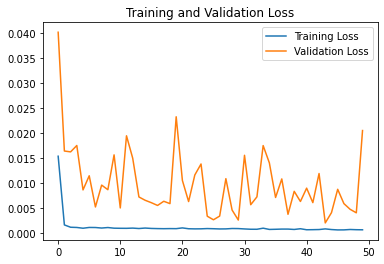

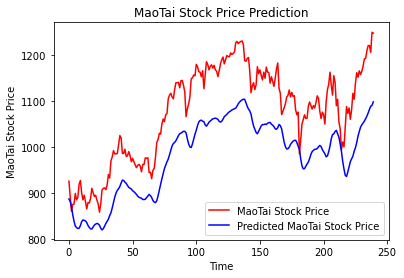

均方误差: 10297.951241
均方根误差: 101.478822
平均绝对误差: 96.158764


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
